In [126]:
import requests
import pickle
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import datetime
import pickle
import seaborn as sns

from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display, HTML

In [2]:
df = pd.read_csv('data', index_col=0, parse_dates=True)

In [3]:
df.head()

,MinutesAsleep,StartTime,Steps,Heartrate
2018-01-01,393.0,2018-01-01T01:20:30.000,10841,71.0
2018-01-02,525.0,2018-01-01T23:26:00.000,12531,69.0
2018-01-03,530.0,2018-01-02T23:15:30.000,11281,67.0
2018-01-04,360.0,2018-01-04T01:17:00.000,25315,65.0
2018-01-05,554.0,2018-01-04T23:44:00.000,11483,64.0


## Summary Statistics

Let's look at the measures of central tendency and spread for each of the features. 

In [4]:
df.describe()

,MinutesAsleep,Steps,Heartrate
count,283.000000,303.000000,298.000000
mean,416.706714,13805.369637,61.238255
std,93.028377,5795.989157,2.915236
min,71.000000,4307.000000,55.000000
25%,367.500000,10261.500000,59.000000
50%,417.000000,12043.000000,61.000000
75%,468.500000,15102.000000,63.000000
max,667.000000,50028.000000,71.000000


Based on the above figures we get a feel for what the data looks like. Minutes Asleep and Steps seem to have high variability whereas Heartrate remains relatively constant. Of course looking at the numbers only tells us so much so lets visualize below. 

## Individual Visualizations 

Here we perform visualizations of each of the features individually to get a sense of what the data looks like for each feature. 

In [5]:
colors = ['blue', 'green', 'red'] # We'll use the same ordering of colors for all graphs to stay consistent. 
features = ['MinutesAsleep', 'Steps', 'Heartrate'] # Likewise we maintain the order of the features. 

### Interpretation of Histograms

All three features appear to be unimodal and roughly gaussian. Minutes Asleep has left skew whereas Steps and Heartrate have right skew. Steps also appear to be heavily concentrated in the 10000 bin, which is no suprise because of the "10000 steps per day" rule!

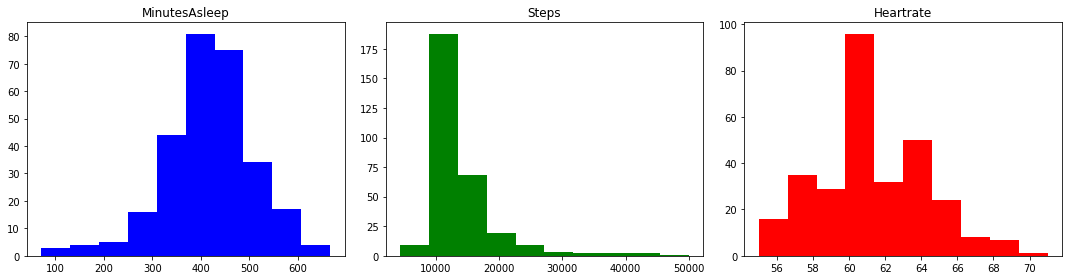

In [6]:
f = plt.figure(figsize=(15,4))
for i, (color, feature) in enumerate(zip(colors, features)):
    ax = f.add_subplot(130 + i + 1)
    ax.hist(df[feature].dropna(),  color=color)
    ax.set_title(feature)
plt.tight_layout()

### Interpretation of Density Plots

The density plots reaffirm normality for each of the features.

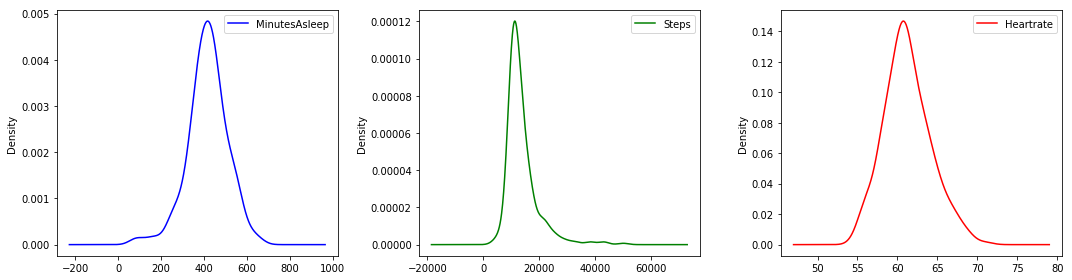

In [7]:
df.plot(kind="density", sharex=False, subplots=True, layout=(1,3), figsize=(15,4), color=colors)
plt.tight_layout()

### Interpretation of Boxplots

The boxplots presents where outliers appear for each of the features. For Minutes Asleep we see outliers on both the high end and low end of the spread, with more appearing in the low end. Steps has  outliers appearing strictly in the high end, which is explained by marathon training. Heartrate has only one outlier. 

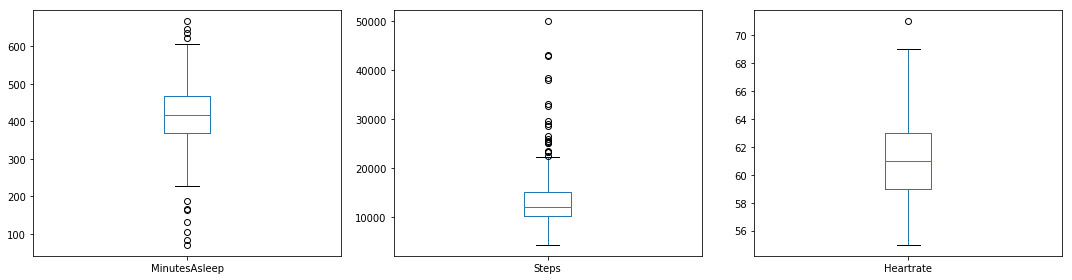

In [8]:
df.plot(kind="box", sharex=False, subplots=True, layout=(1,3), figsize=(15,4))
plt.tight_layout()

### Timeseries Visualization

Now we'll visualize all three features in a time series to see changes throughout the year. This is the most important visualization because it is where we'll identify potential clusters. 

In [9]:
MARATHON_END = mdates.date2num((datetime.datetime(2018,6,4))) # Day after the marathon, officially ending marathon training
SUMMER_END = mdates.date2num((datetime.datetime(2018,9,24))) # First Day of the fall quarter, officially marking the end of Summer

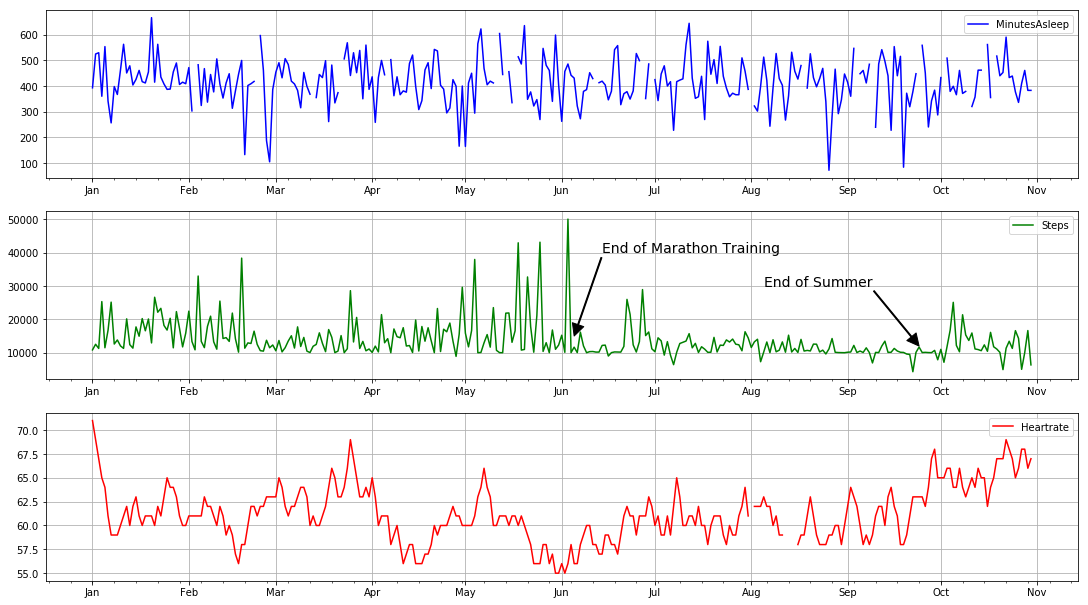

In [10]:
months = mdates.MonthLocator()
weeks = mdates.WeekdayLocator(mdates.MONDAY)
monthsFmt = mdates.DateFormatter('%b')

f = plt.figure()
f.set_size_inches(18.5, 10.5)
for i, (color, feature) in enumerate(zip(colors, features)):
    ax = f.add_subplot(310 + i + 1) # create space on the 3x1 plot for the current feature. 
    ax.plot(df.index.values, df[feature], color=color) # plot the current feature.
    if i == 1: # Annotate the steps plot since that feature has the most apparent patterns. 
        ax.annotate('End of Marathon Training', 
                    xy=((MARATHON_END + 1, 15000)), 
                    xytext=(MARATHON_END + 10, 40000),
                    fontsize=14,
                    arrowprops=dict(facecolor='black', width=1)
                   )
        ax.annotate('End of Summer', 
                    xy=((SUMMER_END, 12000)), 
                    xytext=(SUMMER_END - 50, 30000),
                    fontsize=14,
                    arrowprops=dict(facecolor='black', width=1)
                   )
    ax.grid(True)
    ax.legend()
    ax.xaxis.set_minor_locator(weeks) # tick mark every week
    ax.xaxis.set_major_locator(months) # tick mark every month
    ax.xaxis.set_major_formatter(monthsFmt) # label every month


### Interpretation of Timeseries Plot

When separated by the dates for end of marathon training and end of summer we see different patterns in the number of steps and resting heartrate. Minutes asleep still remains highly variable across all phases so does not tell us much. 

## Aggregate Visualizations 

Now we visualize the pairwise associations between each of the features. This will help us identify if any feature moves in tandem with another. 

**NOTE**: This analysis is not quite appropriate for this dataset because we typically assume independence between observations whereas these observations come from a timeseries which is inherently non-independent. However, we relax this constraint for the sake of demonstrating clustering.  

### Correlational Heatmap

We plot a heatmap of the correlation between every pair of features to determine if there are any strong correlations. As can be seen below, there are no strong correlations. 

(array([0.5, 1.5, 2.5]), <a list of 3 Text yticklabel objects>)

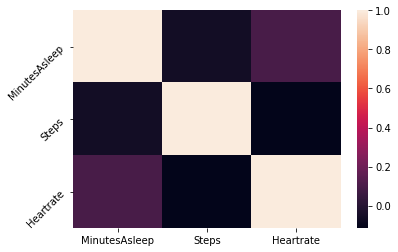

In [66]:
_ = sns.heatmap(df.corr(), 
            xticklabels=df.corr().columns.values,
            yticklabels=df.corr().columns.values)
plt.yticks(rotation=45)

### Scatter Matrix

Here we try to identify a shape to any associations based on pairwise scatter plots. There does not appear to be any apparent patterns, other than that step count has a floor around 10000, which again is a consequence of the "10000 steps per day" rule. 

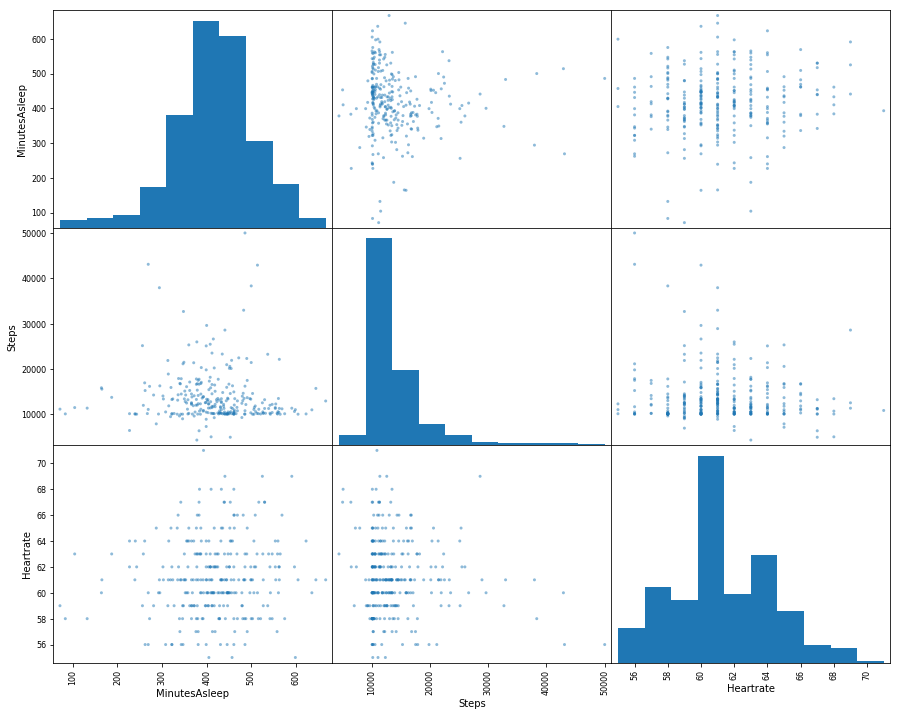

In [17]:
_ = pd.plotting.scatter_matrix(df, figsize=(15,12))

### 3D Scatterplot

This is the final method for visualizing the clusters we're interested in. Each observation will be plotted in a 3d grid with each of the features as a dimension in that grid. Then, the obersvations will be colored according to what time of the year they were generated. We will compare this visualization to how EM clusters the datapoints. 

In [58]:
df_nona = df.dropna() # We only want to plot observations where we have complete data

In [74]:
marathon_idx = df_nona.index.get_loc('2018-06-04') # Find out where in the dataframe marathon training ended...

In [75]:
summer_idx = df_nona.index.get_loc('2018-09-26') # ...also for when summer ended. 

In [117]:
cluster_colors = ["green"] * (marathon_idx) # Marathon cluster -> purple
cluster_colors.extend(["red"] * (summer_idx - marathon_idx)) # Summer cluster -> orange
cluster_colors.extend(['blue'] * (len(df_nona) - summer_idx)) # Fall quarter -> grey

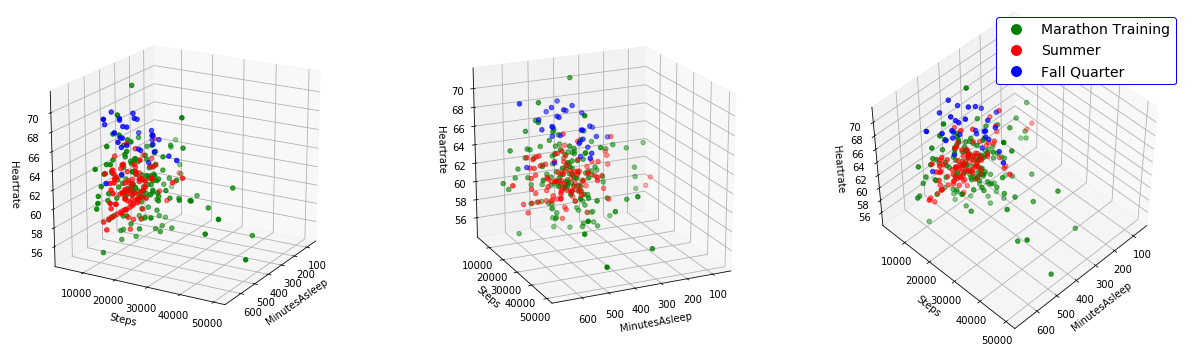

In [131]:
elevations = [20, 20, 50]
azimuths = [30, 65, 45]

fig = plt.figure(figsize=(21,6))
for i, (elv, azm) in enumerate(zip(elevations, azimuths)):
    ax = fig.add_subplot(1, 3, i+1, projection='3d')
    ax.scatter(df[features[0]], df[features[1]], df[features[2]], color = cluster_colors)
    ax.set_xlabel(features[0])
    ax.set_ylabel(features[1])
    ax.set_zlabel(features[2])
    ax.view_init(elv, azm)

legend_elements = [Line2D([0], [0], color='w', markerfacecolor='green', marker = 'o', markersize=12, label='Marathon Training'),
                   Line2D([0], [0], color='w', markerfacecolor='red', marker = 'o', markersize=12, label='Summer'),
                   Line2D([0], [0], color='w', markerfacecolor='blue',   marker = 'o', markersize=12, label='Fall Quarter')]

ax = plt.gca()
leg = ax.legend(handles = legend_elements, prop={'size': 14}, fontsize=14, framealpha=1)
leg.get_frame().set_edgecolor('b')
fig.savefig('groundtruth_clusters.png', transparent=True)

### Interpretation of 3D Scatterplot

The 3d cluster above does demonstrate some identifiable patterns. First, we see that only the observations from marathon training extend past 20000 in the steps axis, and that heartrates in the Fall quarter cluster have heartrates strictly above 62. Finally, observations from the Summer cluster are pretty concentrated in the center of the data, which reaffirms the line graph visualizations from above. 

# Conclusion

Above we performed various visualizations and reporting of the data to understand what the data looks like and what relationships there may be between the data. From the individual visualizations we understand the dispersion and central tendencies of each feature. From the aggregate visulaizations we see that the features don't have strong associations between themselves, but the 3d scatter plot helped us see the clusters that are apparent when we consider significant periods (marathon training, Summer, Fall quarter) throughout the year. We'll use each of these representations to guide our understanding and interpretation of the results we get from performing Expectation Maxmimization on the data. 